# Importing Module and define directories

In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler, MinMaxScaler

from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble
from utils.losses import MEE
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations


#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Fit the curve with all data

In [2]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)


other_output= labels[:,0]
lin_output= labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((data, labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'vecstd')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

## Try an ensemble

In [3]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [4]:
raw_data=np.loadtxt("../../data/Data_set.txt")
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                        frac_training=frac_training)

In [5]:
n_candidates=5

list_dict_MLP=[{'structure':[10,5, labels.shape[-1]],
            'func':["tanh","relu","linear"],
            'starting_points':xavier([10,5,2])},

            {'structure':[10,20, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,20,2])},

            {'structure':[10,10, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,10,2])},

            {'structure':[10,10,10, labels.shape[-1]],
            'func':["tanh","tanh","tanh","linear"],
            'starting_points':xavier([10,10,10,2])}]

list_dict_train=[{'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':200,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-5,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-7,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True}]


In [6]:
N_ensamble=10
bagg = bagging_ensemble(N_ensamble)
bootstrap=False

for dict_MLP,dict_train in zip(list_dict_MLP,list_dict_train):
    bagg.train(input_data, train_labels , val_data, val_labels,
            MLP_w, dict_MLP, dict_train, bootstrap = bootstrap)

0/1
Candidate 0
Epoch 2085:  [train MEE = 0.1480]  [val MEE = 0.1735]                              
Elapsed time: 5.847569704055786 s
1/2
Candidate 0
Epoch 1567:  [train MEE = 0.1424]  [val MEE = 0.1636]                              
Elapsed time: 6.827946186065674 s
2/3
Candidate 0
Epoch 3046:  [train MEE = 0.1374]  [val MEE = 0.1630]                              
Elapsed time: 10.192940473556519 s
3/4
Candidate 0
Epoch 2502:  [train MEE = 0.1357]  [val MEE = 0.1587]                              
Elapsed time: 11.504443645477295 s


In [7]:
bagg.prune_ensemble

Pruned 1/4 classifier


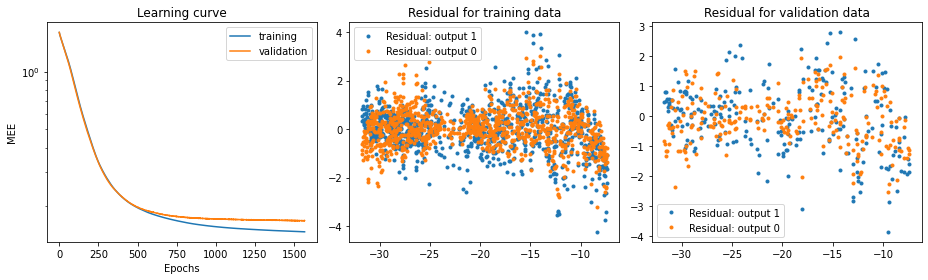

final train error: 0.9803970741233768
final val error: 1.1578440233344873


In [8]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

plot_results(bagg, input_data, val_data, train_labels, val_labels,
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = True)

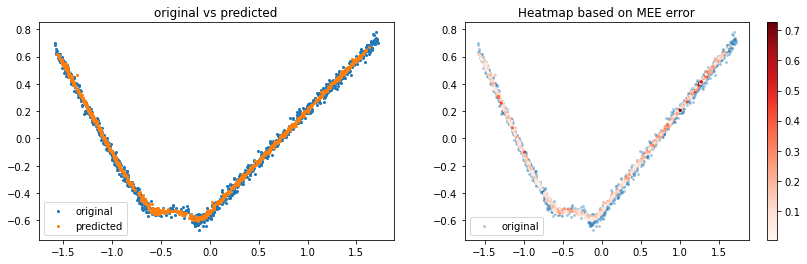

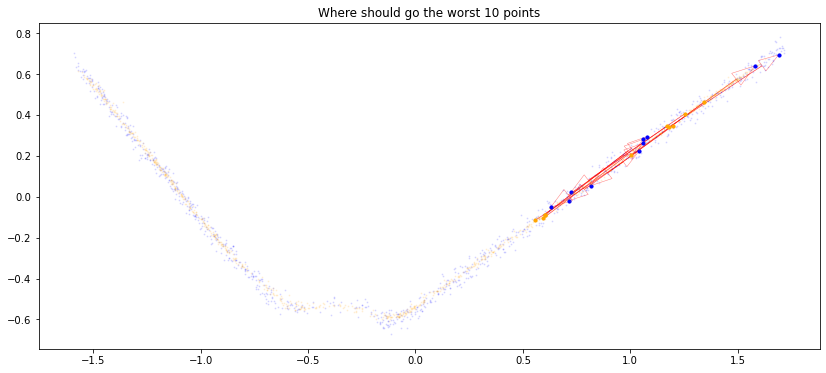

[101 118   8 755 857  67 557 844 623 722]


In [9]:
w_worst = output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

print(w_worst)

# Performance evaluation on test set

In [10]:
raw_test=np.loadtxt("../../data/Test_set.txt")
test_data = raw_test[:,:10] ; test_labels = raw_test[:,-2:]
test_data = norm_data.transform(test_data)

In [11]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble
bagg_test_predict=bagg.predict(test_data,func=lin_sin_lin, param=popt_sin)
bagg_test_predict=norm_labels.inverse_transform(bagg_test_predict)
MEE(bagg_test_predict, test_labels)

1.0769653579033096

# Retrain the ensambling on all data

In [12]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

In [14]:
N_ensamble=10
bagg = bagging_ensemble(N_ensamble)
bootstrap=False

## PROBLEMA::: NON c'è validation, la patience non si può più usare
#come is ferma il training?

for dict_MLP,dict_train in zip(list_dict_MLP,list_dict_train):
    bagg.train(data, labels , data, labels,
            MLP_w, dict_MLP, dict_train, bootstrap = bootstrap)

0/1
Candidate 0
Epoch 3660:  [train MEE = 0.1400]  [val MEE = 0.1400]                              
Elapsed time: 15.350902795791626 s
1/2
Candidate 0
Epoch 2137:  [train MEE = 0.1435]  [val MEE = 0.1436]                              
Elapsed time: 111.21575903892517 s
2/3
Candidate 0
Epoch 4374:  [train MEE = 0.1372]  [val MEE = 0.1372]                              
Elapsed time: 23.610859870910645 s
3/4
Candidate 0
Epoch 1745:  [train MEE = 0.1444]  [val MEE = 0.1446]                              
Elapsed time: 12.952484607696533 s


In [ ]:
bagg.prune_ensemble

# Blind test set prediction

In [ ]:
blind_data=np.loadtxt("../../data/TS.csv",delimiter=",")[:,1:]
blind_data = norm_data.fit_transform(blind_data)
out_prediction=norm_labels.inverse_transform(bagg.predict(blind_data))

In [ ]:
out_matrix=np.c_[np.arange(1,len(out_prediction)+1).astype(int),out_prediction]
team_name="zio_pino"
file_path=data_dir+f'{team_name}_ML-CUP21-TS.csv'
with open(file_path,'w',newline='') as file:
    file.write(f"#Piero Viscone, Edoardo Gabrielli, Adriano Del Vincio\n")
    file.write(f"#{team_name}\n")
    file.write(f"#ML-CUP21 v1\n")
    file.write(f"#4 Gennaio 2022\n")
    np.savetxt(file,out_matrix,delimiter=",",fmt="%i,%f,%f")

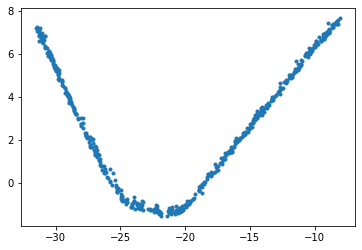

In [ ]:
plt.plot(out_prediction[:,1],out_prediction[:,0],'.')